# CoG paper experiments

In [1]:
from pcgsepy.setup_utils import setup_matplotlib, get_default_lsystem
from typing import List
import numpy as np
from pcgsepy.lsystem.solution import CandidateSolution

setup_matplotlib(larger_fonts=False)

used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

lsystem = get_default_lsystem(used_ll_blocks=used_ll_blocks)

## Plotting and saving utils

In [2]:
def plot_mean_and_top_feasible(ffs,
                               exp_name,
                               dir_name):
    ftfs = np.max(ffs, axis=2)
    fmfs = np.mean(ffs, axis=2)

    ftm = np.mean(ftfs, axis=0)
    fts = np.std(ftfs, axis=0)

    fmm = np.mean(fmfs, axis=0)
    fms = np.std(fmfs, axis=0)

    plt.grid()
    plt.plot(range(len(ftm)), ftm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(fts)), (ftm - (.5 * fts)), (ftm + (.5 * fts)), color='blue', alpha=0.2)
    plt.fill_between(range(len(fts)), (ftm - fts), (ftm + fts), color='blue', alpha=0.1)
    plt.plot(range(len(fmm)), fmm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(fms)), (fmm - (.5 * fms)), (fmm + (.5 * fms)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(fms)), (fmm - fms), (fmm + fms), color='darkgreen', alpha=0.1)
    plt.legend(loc='lower right')
    plt.title(f'Avg. FPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{dir_name}/{exp_name}-fpop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [3]:
def plot_mean_and_top_infeasible(ifs,
                                 exp_name,
                                 dir_name):
    itfs = np.max(ifs, axis=2)
    imfs = np.mean(ifs, axis=2)

    itm = np.mean(itfs, axis=0)
    its = np.std(itfs, axis=0)

    imm = np.mean(imfs, axis=0)
    ims = np.std(imfs, axis=0)

    plt.grid()
    plt.plot(range(len(itm)), itm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(its)), (itm - (.5 * its)), (itm + (.5 * its)), color='blue', alpha=0.2)
    plt.fill_between(range(len(its)), (itm - its), (itm + its), color='blue', alpha=0.1)
    plt.plot(range(len(imm)), imm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(ims)), (imm - (.5 * ims)), (imm + (.5 * ims)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(ims)), (imm - ims), (imm + ims), color='darkgreen', alpha=0.1)
    plt.legend(loc='upper right')
    plt.title(f'Avg. IPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{dir_name}/{exp_name}-ipop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [4]:
def plot_coverage(coverages_hist,
                  exp_name,
                  title: str,
                  filename: str,
                  dir_name):
    mean_coverage = np.mean(coverages_hist, axis=0)
    std_coverage = np.std(coverages_hist, axis=0)
    
    plt.grid()
    plt.plot(range(len(mean_coverage)), mean_coverage, label=f'Avg. coverage', c='blue', lw=2)
    plt.fill_between(range(len(std_coverage)), (mean_coverage - (.5 * std_coverage)), (mean_coverage + (.5 * std_coverage)), color='blue', alpha=0.2)
    plt.fill_between(range(len(std_coverage)), (mean_coverage - std_coverage), (mean_coverage + std_coverage), color='blue', alpha=0.1)
    plt.legend(loc='lower right')
    plt.title(title, pad=PAD_TITLE_SIZE)
    plt.ylabel('Coverage', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{dir_name}/{filename}-{exp_name}.png', transparent=True, bbox_inches='tight')
    plt.show()

In [5]:
import scipy.stats as st

def plot_compare(arrs: List[np.ndarray],
                 colors: List[str],
                 linestyles: List[str],
                 labels: List[str],
                 title: str,
                 partial_filename: str,
                 dir_name: str,
                 add_area: bool = True,
                 plot_elites: bool = True,
                 legend_loc: str = 'lower right'):
    plt.grid()
    for arr, color, label, linestyle in zip(arrs, colors, labels, linestyles):
        values = arr[:,:,0] if plot_elites else arr[:,:,1]
        values_mean = np.mean(values, axis=0)
        
        plt.plot(range(len(values_mean)), values_mean, label=label, c=color, lw=2, linestyle=linestyle)
        if add_area:
            # values_std = np.std(values, axis=0)
            
            # 95 confidence interval
            confidence = 0.95
            upper_confidence_intervals = np.percentile(values_mean, 100 * (1 - confidence) / 2)
            lower_confidence_intervals = np.percentile(values_mean, 100 * (1 - (1 - confidence) / 2))
            
            upper_confidence_intervals, lower_confidence_intervals = st.t.interval(0.95, len(values) - 1, loc=values_mean, scale=st.sem(values))
            
            # plt.fill_between(range(len(values_std)), (values_mean - (.5 * values_std)), (values_mean + (.5 * values_std)), color=color, alpha=0.05)
            # plt.fill_between(range(len(values_std)), (values_mean - values_std), (values_mean + values_std), color=color, alpha=0.01)
            plt.fill_between(range(len(values_mean)), lower_confidence_intervals, upper_confidence_intervals, color=color, alpha=0.1)
    
    plt.legend(loc=legend_loc)
    plt.title(title, pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness' if 'fitness' in partial_filename else 'Coverage', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{dir_name}/comparison-{partial_filename}.png', transparent=True, bbox_inches='tight')
    plt.show()

In [6]:
def print_stats(arr: np.ndarray,
                title: str,
                elites: bool = True):
    values = arr[:,:,0] if elites else arr[:,:,1]
    values_mean = np.mean(values, axis=0)
    values_std = np.std(values, axis=0)
    print(f'{title}: {np.round(values_mean[-1], 4)} +- {np.round(values_std[-1], 4)}')

In [7]:
def save_metrics(f_fitnesses_hist,
                 i_fitnesses_hist,
                 exp_name,
                 dir_name):
    ffs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(f_fitnesses_hist):
        for g, gv in enumerate(rv):
            ffs[r, g, :] = gv
    ifs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(i_fitnesses_hist):
        for g, gv in enumerate(rv):
            ifs[r, g, :] = gv
    with open(f'results/{dir_name}/{exp_name}_metrics.npz', 'wb') as f:
        np.savez(f, ffs, ifs)
        
def save_coverage(f_coverages,
                  i_coverages,
                  exp_name,
                  dir_name):
    fcs = np.empty(shape=(N_RUNS, 1 + N_GENS))
    for r, rv in enumerate(f_coverages):
        fcs[r, :] = rv
    ics = np.empty(shape=(N_RUNS, 1 + N_GENS))
    for r, rv in enumerate(i_coverages):
        ics[r, :] = rv
    with open(f'results/{dir_name}/{exp_name}_coverages.npz', 'wb') as f:
        np.savez(f, fcs, ics)

In [8]:
def save_solution_stats(cs: CandidateSolution,
                        exp_name: str,
                        dir_name: str) -> None:
    with open(f'results/{dir_name}/{exp_name}_atoms.log', 'a') as f:
        f.write(f'\n\n{cs.string}')
        f.write(f'\nFitness: {cs.fitness}')

## Experiments settings

In [9]:
run_experiments = {
    1: False,
    2: False,
    3: False,
    4: False,
    5: False,
    6: False,
    7: False
}
plot_experiments_results = {
    1: False,
    2: False,
    3: False,
    4: False,
    5: False,
    6: False,
    7: False
}

In [10]:
from pcgsepy.evo.genops import expander

expander.initialize(rules=lsystem.hl_solver.parser.rules)

In [11]:
from pcgsepy.config import N_RUNS, N_GENS
from tqdm.notebook import trange
import matplotlib.pyplot as plt

PAD_TITLE_SIZE = 20
PAD_LABEL_SIZE = 10

In [12]:
from pcgsepy.evo.fitness import *

feasible_fitnesses = [
    Fitness(name='BoxFilling',
            f=box_filling_fitness,
            bounds=(0, 1)),
    Fitness(name='FuncionalBlocks',
            f=func_blocks_fitness,
            bounds=(0, 1)),
    Fitness(name='MajorMediumProportions',
            f=mame_fitness,
            bounds=(0, 1)),
    Fitness(name='MajorMinimumProportions',
            f=mami_fitness,
            bounds=(0, 1))
]

## Experiment 1

Run standard FI-2Pop against variant FI-2Pop

### FI-2Pop variant

In [13]:
from typing import Any, Dict, List, Tuple, Optional, Union

import torch as th
import numpy as np
from tqdm.notebook import trange

from pcgsepy.config import N_GENS, N_ITERATIONS, N_RETRIES, POP_SIZE, EPSILON_F
from pcgsepy.evo.fitness import Fitness
from pcgsepy.lsystem.constraints import ConstraintLevel
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.lsystem.solution import CandidateSolution
from pcgsepy.fi2pop.utils import create_new_pool, reduce_population, subdivide_solutions

from pcgsepy.fi2pop.utils import MLPEstimator, GaussianEstimator, prepare_dataset, train_estimator
from pcgsepy.mapelites.buffer import Buffer, EmptyBufferException

class FI2PopVariantSolver:
    def __init__(self,
                 feasible_fitnesses: List[Fitness],
                 lsystem: LSystem,
                 buffer: Buffer,
                 estimator: Optional[Union[GaussianEstimator, MLPEstimator]] = None):
        """Create the FI2Pop solver.

        Args:
            feasible_fitnesses (List[Fitness]): The list of fitnesses.
            lsystem (LSystem): The L-system object.
        """
        self.feasible_fitnesses = feasible_fitnesses
        self.lsystem = lsystem
        self.ftop = []
        self.itop = []
        self.fmean = []
        self.imean = []

        self.ffs, self.ifs = [], []

        # number of total soft constraints
        self.nsc = [c for c in self.lsystem.all_hl_constraints if c.level == ConstraintLevel.SOFT_CONSTRAINT]
        self.nsc = [c for c in self.lsystem.all_ll_constraints if c.level == ConstraintLevel.SOFT_CONSTRAINT]
        self.nsc = len(self.nsc) * 0.5
        
        self.estimator = estimator
        self.buffer = buffer
        self.max_f_fitness = sum([f.bounds[1] for f in self.feasible_fitnesses])

    def reset(self):
        self.ftop = []
        self.itop = []
        self.fmean = []
        self.imean = []
        self.ffs, self.ifs = [], []
        
        self.estimator = MLPEstimator(len(self.feasible_fitnesses), 1)
        self.buffer = Buffer(merge_method=self.buffer._merge)

    def _compute_fitness(self,
                         cs: CandidateSolution,
                         extra_args: Dict[str, Any]) -> List[float]:
        """Compute the fitness of a single candidate solution.

        Args:
            cs (CandidateSolution): The candidate solution.
            extra_args (Dict[str, Any]): Additional arguments used in the fitness function.

        Returns:
            float: The fitness value.
        """
        if cs.fitness == []:
            fs = [f(cs, extra_args) for f in self.feasible_fitnesses]
            cs.fitness = fs
        if cs.is_feasible:
            return sum(cs.fitness)
        else:
            if isinstance(self.estimator, GaussianEstimator):
                return self.estimator.predict(x=np.asarray(cs.fitness))
            elif isinstance(self.estimator, MLPEstimator):
                if self.estimator.is_trained:
                    with th.no_grad():
                        return self.estimator(th.tensor(cs.fitness).float()).numpy()[0]
                else:
                    return EPSILON_F
            else:
                raise NotImplementedError(f'Unrecognized estimator type: {type(self.estimator)}.')

    def _generate_initial_populations(self,
                                      pops_size: int = POP_SIZE,
                                      n_retries: int = N_RETRIES) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Generate the initial populations.

        Args:
            pops_size (int, optional): The size of the population. Defaults to POP_SIZE.
            n_retries (int, optional): The number of retries. Defaults to N_RETRIES.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and Infeasible populations.
        """
        feasible_pop, infeasible_pop = [], []
        self.lsystem.disable_sat_check()
        with trange(n_retries, desc='Initialization ') as iterations:
            for i in iterations:
                solutions = self.lsystem.apply_rules(starting_strings=['head', 'body', 'tail'],
                                                     iterations=[1, N_ITERATIONS, 1],
                                                     create_structures=False,
                                                     make_graph=False)
                subdivide_solutions(lcs=solutions,
                                    lsystem=self.lsystem)
                for cs in solutions:
                    if cs.is_feasible and len(feasible_pop) < pops_size and cs not in feasible_pop:
                        feasible_pop.append(cs)
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                           extra_args={
                                                               'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                               }) + (self.nsc - cs.ncv)
                    elif not cs.is_feasible and len(infeasible_pop) < pops_size and cs not in feasible_pop:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                                 })
                        infeasible_pop.append(cs)
                iterations.set_postfix(ordered_dict={'fpop-size': f'{len(feasible_pop)}/{pops_size}',
                                                     'ipop-size': f'{len(infeasible_pop)}/{pops_size}'},
                                       refresh=True)
                if i == n_retries or (len(feasible_pop) == pops_size and len(infeasible_pop) == pops_size):
                    break
        return feasible_pop, infeasible_pop

    def initialize(self,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Initialize the solver by generating the initial populations.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and Infeasible populations.
        """
        f_pop, i_pop = self._generate_initial_populations(pops_size=pops_size,
                                                          n_retries=n_retries)
        f_fitnesses = [cs.c_fitness for cs in f_pop]
        i_fitnesses = [cs.c_fitness for cs in i_pop]
        self.ftop.append(max(f_fitnesses))
        self.fmean.append(sum(f_fitnesses) / len(f_fitnesses))
        self.itop.append(max(i_fitnesses))
        self.imean.append(sum(i_fitnesses) / len(i_fitnesses))
        self.ffs.append([self.ftop[-1], self.fmean[-1]])
        self.ifs.append([self.itop[-1], self.imean[-1]])
        print(f'Created Feasible population of size {len(f_pop)}: t:{self.ftop[-1]};m:{self.fmean[-1]}')
        print(f'Created Infeasible population of size {len(i_pop)}: t:{self.itop[-1]};m:{self.imean[-1]}')
        return f_pop, i_pop

    def fi2pop(self,
               f_pop: List[CandidateSolution],
               i_pop: List[CandidateSolution],
               n_iter: int = N_GENS) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Apply the FI2Pop algorithm to the given populations for `n_iter` steps.

        Args:
            f_pop (List[CandidateSolution]): The Feasible population.
            i_pop (List[CandidateSolution]): The Infeasible population.
            n_iter (int, optional): The number of iterations to run for. Defaults to N_GENS.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and the Infeasible populations.
        """
        f_pool = []
        i_pool = []
        with trange(n_iter, desc='Generation ') as gens:
            for gen in gens:
                # place the infeasible population in the infeasible pool
                i_pool.extend(i_pop)
                
                f_pool.extend(f_pop)
                
                # create offsprings from feasible population
                new_pool = create_new_pool(population=f_pop,
                                           generation=gen)
                # if feasible, add to feasible pool
                # if infeasible, add to infeasible pool
                subdivide_solutions(lcs=new_pool,
                                    lsystem=self.lsystem)
                for cs in new_pool:
                    if cs.is_feasible:
                        f_pool.append(cs)
                        cs.ll_string = self.lsystem.hl_to_ll(cs=cs).string
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             }) + (self.nsc - cs.ncv)
                    else:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             })
                        i_pool.append(cs)
                # place the infeasible population in the infeasible pool
                # i_pool.extend(i_pop)s                                  
                
                i_pool = list(set(i_pool))
                
                # reduce the infeasible pool if > pops_size
                if len(i_pool) > POP_SIZE:
                    i_pool = reduce_population(population=i_pool,
                                               to=POP_SIZE,
                                               minimize=False)
                # set the infeasible pool as the infeasible population
                i_pop[:] = i_pool[:]
                # create offsprings from infeasible population
                new_pool = create_new_pool(population=i_pop,
                                           generation=gen,
                                           minimize=False)
                # if feasible, add to feasible pool
                # if infeasible, add to infeasible pool
                subdivide_solutions(lcs=new_pool,
                                    lsystem=self.lsystem)
                for cs in new_pool:
                    if cs.is_feasible:
                        f_pool.append(cs)
                        cs.ll_string = self.lsystem.hl_to_ll(cs=cs).string
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             }) + (self.nsc - cs.ncv)
                    else:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             })
                        i_pool.append(cs)
                
                f_pool = list(set(f_pool)) 
                
                # Prepare dataset for estimator
                xs, ys = prepare_dataset(f_pop=f_pool)
                for x, y in zip(xs, ys):
                    self.buffer.insert(x=x,
                                       y=y / self.max_f_fitness)
                # If possible, train estimator
                try:
                    xs, ys = self.buffer.get()
                    if isinstance(self.estimator, GaussianEstimator):
                        self.estimator.fit(x=xs,
                                            y=ys)
                    elif isinstance(self.estimator, MLPEstimator):
                        train_estimator(self.estimator,
                                        xs=xs,
                                        ys=ys)
                    else:
                        raise NotImplementedError(f'Unrecognized estimator type {type(self.estimator)}.')
                except EmptyBufferException as e:
                    pass
                if self.estimator.is_trained:
                    # Reassign previous infeasible fitnesses
                        for cs in i_pool:
                            cs.c_fitness = self._compute_fitness(cs=cs,
                                                                extra_args={
                                                                    'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                                    })      
                
                # reduce the feasible pool if > pops_size
                if len(f_pool) > POP_SIZE:
                    f_pool = reduce_population(population=f_pool,
                                               to=POP_SIZE)
                # set the feasible pool as the feasible population
                f_pop[:] = f_pool[:]
                # update tracking
                f_fitnesses = [cs.c_fitness for cs in f_pop]
                i_fitnesses = [cs.c_fitness for cs in i_pop]
                self.ftop.append(max(f_fitnesses))
                self.fmean.append(sum(f_fitnesses) / len(f_fitnesses))
                self.itop.append(max(i_fitnesses))
                self.imean.append(sum(i_fitnesses) / len(i_fitnesses))
                self.ffs.append([self.ftop[-1], self.fmean[-1]])
                self.ifs.append([self.itop[-1], self.imean[-1]])
                gens.set_postfix(ordered_dict={'top-f': self.ftop[-1],
                                               'mean-f': self.fmean[-1],
                                               'top-i': self.itop[-1],
                                               'mean-i': self.imean[-1]},
                                 refresh=True)

        return f_pop, i_pop


### Run

In [14]:
def run_experiment(solver,
                   exp_name,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    i_fitnesses_hist = []
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            solver.reset()         
            f_pop, i_pop = solver.initialize(pops_size=pops_size,
                                             n_retries=n_retries)
            f_pop, i_pop = solver.fi2pop(f_pop=f_pop,
                                         i_pop=i_pop,
                                         n_iter=N_GENS)
            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)
            f_fitnesses = [cs.c_fitness for cs in f_pop]
            i_fitnesses = [cs.ncv for cs in f_pop]
            save_solution_stats(cs=f_pop[f_fitnesses.index(max(f_fitnesses))],
                                exp_name=exp_name,
                                dir_name='cog_experiment01')
            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.max(i_fitnesses) if isinstance(solver, FI2PopVariantSolver) else np.min(i_fitnesses)},
                                   refresh=True)
            
    return f_fitnesses_hist, i_fitnesses_hist


In [15]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.fi2pop.fi2pop import FI2PopSolver

if run_experiments[1]:
    solvers, exp_names = [], []

    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        solver = FI2PopVariantSolver(feasible_fitnesses=feasible_fitnesses,
                                    lsystem=lsystem,
                                    buffer=buffer,
                                    estimator=MLPEstimator(len(feasible_fitnesses), 1))
        exp_name = f'variant-fi2pop-{buffer._merge.__name__}'
        
        solvers.append(solver)
        exp_names.append(exp_name)

    solvers.append(FI2PopSolver(feasible_fitnesses=feasible_fitnesses,
                                lsystem=lsystem))
    exp_names.append('standard-fi2pop')

    for solver, exp_name in zip(solvers, exp_names):
        f_fitnesses_hist, i_fitnesses_hist = run_experiment(solver=solver,
                                                            exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment01')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                exp_name=exp_name,
                                dir_name='cog_experiment01')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                    exp_name=exp_name,
                                    dir_name='cog_experiment01')


In [16]:
if plot_experiments_results[1]:
    experiments = {'standard-fi2pop': {}, 
                'variant-fi2pop-max_merge': {},
                'variant-fi2pop-mean_merge': {},
                'variant-fi2pop-min_merge': {}
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment01/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']

    feas_arrs = []
    infeas_arrs = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        labels.append(experiment)
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        
    colors = ['darkgreen', 'blue', 'blue', 'blue']
    linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment01',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment01',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment01',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment01',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')

## Experiment 2

Run standard MAP-Elites against variant MAP-Elites (w/ RandomEmitter).

In [17]:
from pcgsepy.mapelites.map import MAPElites

def run_experiment(mapelites: MAPElites,
                   exp_name: str,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    f_coverages_hist = []
    i_fitnesses_hist = []
    i_coverages_hist = []
    with open('estimators_perf.log', 'a') as f:
        f.write(f'Running experiment {exp_name}\n')
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            with open('estimators_perf.log', 'a') as f:
                f.write(f'Run {n+1}/`{N_RUNS}\n')
            f_fitnesses, i_fitnesses = [], []
            f_coverages, i_coverages = [], []
            mapelites.reset()
            mapelites.hull_builder = None
            mapelites.generate_initial_populations(pops_size=pops_size,
                                                   n_retries=n_retries)
            f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
            i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
            fc_curr, total = mapelites.get_coverage(pop='feasible')
            ic_curr, _ = mapelites.get_coverage(pop='infeasible')
            f_coverages.append(fc_curr)
            i_coverages.append(ic_curr)
            with trange(N_GENS, desc=f'Running MAP-Elites (run {n+1})...') as gens:
                for gen in gens:
                    mapelites.emitter_step(gen=gen)
                    f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
                    i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
                    fc_curr, total = mapelites.get_coverage(pop='feasible')
                    ic_curr, _ = mapelites.get_coverage(pop='infeasible')
                    f_coverages.append(fc_curr)
                    i_coverages.append(ic_curr)                    
                    if gen == N_GENS - 1:
                        f_coverages = [x / total for x in f_coverages]
                        i_coverages = [x / total for x in i_coverages]
                    gens.set_postfix(ordered_dict={'f_top_fit': f_fitnesses[-1][0],
                                                   'f_avg_fit': f_fitnesses[-1][1],
                                                   'i_top_fit': i_fitnesses[-1][0],
                                                   'i_avg_fit': i_fitnesses[-1][1]},
                                     refresh=True)
                f_fitnesses_hist.append(f_fitnesses)
                i_fitnesses_hist.append(i_fitnesses)
                f_coverages_hist.append(f_coverages)
                i_coverages_hist.append(i_coverages)
                save_solution_stats(cs=mapelites.get_random_elite(pop='feasible'),
                                    exp_name=exp_name,
                                    dir_name='cog_experiment02')
            iterations.set_postfix(ordered_dict={'f_coverage': f_coverages_hist[-1][-1],
                                                 'i_coverages': i_coverages_hist[-1][-1]})
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='feasible',
                                  save_as=f'cog_experiment02/{exp_name}-run{str(n).zfill(2)}')
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='infeasible',
                                  save_as=f'cog_experiment02/{exp_name}-run{str(n).zfill(2)}')
    return f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist


In [18]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.mapelites.behaviors import BehaviorCharacterization, mame, mami
from pcgsepy.mapelites.emitters import RandomEmitter

if run_experiments[2]:
    l_mapelites, exp_names = [], []

    behavior_descriptors = (BehaviorCharacterization(name='mame',
                                                     func=mame,
                                                     bounds=(0, 20)),
                            BehaviorCharacterization(name='mami',
                                                     func=mami,
                                                     bounds=(0, 20)))
    
    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        mapelites = MAPElites(lsystem=lsystem,
                              feasible_fitnesses=feasible_fitnesses,
                              estimator=MLPEstimator(xshape=len(feasible_fitnesses),
                                                     yshape=1),
                              buffer=buffer,
                              behavior_descriptors=behavior_descriptors,
                              n_bins=(32,32),
                              emitter=RandomEmitter())
        mapelites.allow_aging = False
        mapelites.allow_res_increase = False
        exp_name = f'variant-mapelites-{buffer._merge.__name__}'
        l_mapelites.append(mapelites)
        exp_names.append(exp_name)

    l_mapelites.append(MAPElites(lsystem=lsystem,
                              feasible_fitnesses=feasible_fitnesses,
                              estimator=None,
                              buffer=Buffer(merge_method=mean_merge),  # unused anyways
                              behavior_descriptors=behavior_descriptors,
                              n_bins=(32,32),
                              emitter=RandomEmitter()))
    l_mapelites[-1].allow_aging = False
    l_mapelites[-1].allow_res_increase = False
    exp_names.append('standard-mapelites')

    for mapelites, exp_name in zip(l_mapelites, exp_names):
        f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist = run_experiment(mapelites=mapelites,
                                                                                                exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment02')
        save_coverage(f_coverages=f_coverages_hist,
                      i_coverages=i_coverages_hist,
                      exp_name=exp_name,
                      dir_name='cog_experiment02')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                   exp_name=exp_name,
                                   dir_name='cog_experiment02')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                     exp_name=exp_name,
                                     dir_name='cog_experiment02')
        plot_coverage(coverages_hist=f_coverages_hist,
                      title=f'Avg. Feasible coverage',
                      exp_name=exp_name,
                      filename='avg-feas-coverage',
                      dir_name='cog_experiment02')
        plot_coverage(coverages_hist=i_coverages_hist,
                      title=f'Avg. Infeasible coverage',
                      exp_name=exp_name,
                      filename='avg-infeas-coverage',
                      dir_name='cog_experiment02')


In [19]:
if plot_experiments_results[2]:
    experiments = {'standard-mapelites': {}, 
                'variant-mapelites-max_merge': {},
                'variant-mapelites-mean_merge': {},
                'variant-mapelites-min_merge': {}
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment02/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']
        with open(f'results/cog_experiment02/{experiment}_coverages.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible_coverage'] = np.expand_dims(npzfile['arr_0'], 2)
            experiments[experiment]['infeasible_coverage'] = np.expand_dims(npzfile['arr_1'], 2)
        
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['feasible_coverage'],
                    title=f'{experiment}-feas-coverage',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible_coverage'],
                    title=f'{experiment}-infeas-coverage',
                    elites=True)

    feas_arrs = []
    infeas_arrs = []
    feas_coverages = []
    infeas_coverages = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        feas_coverages.append(experiments[experiment]['feasible_coverage'])
        infeas_coverages.append(experiments[experiment]['infeasible_coverage'])
        labels.append(experiment)
    colors = ['darkgreen', 'blue', 'blue', 'blue']
    linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')
    
    plot_compare(arrs=feas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Average Feasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')
    
    plot_compare(arrs=infeas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment02',
                title=f'Average Ineasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')

## Experiment 3

Run variant MAP-Elites w/ OptimisationEmitter.

In [20]:
from pcgsepy.mapelites.map import MAPElites

def run_experiment(mapelites: MAPElites,
                   exp_name: str,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    f_coverages_hist = []
    i_fitnesses_hist = []
    i_coverages_hist = []
    with open('estimators_perf.log', 'a') as f:
        f.write(f'Running experiment {exp_name}\n')
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            with open('estimators_perf.log', 'a') as f:
                f.write(f'Run {n+1}/`{N_RUNS}\n')
            f_fitnesses, i_fitnesses = [], []
            f_coverages, i_coverages = [], []
            mapelites.reset()
            mapelites.hull_builder = None
            mapelites.generate_initial_populations(pops_size=pops_size,
                                                   n_retries=n_retries)
            f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
            i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
            fc_curr, total = mapelites.get_coverage(pop='feasible')
            ic_curr, _ = mapelites.get_coverage(pop='infeasible')
            f_coverages.append(fc_curr)
            i_coverages.append(ic_curr)
            with trange(N_GENS, desc=f'Running MAP-Elites (run {n+1})...') as gens:
                for gen in gens:
                    mapelites.emitter_step(gen=gen)
                    f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
                    i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
                    fc_curr, total = mapelites.get_coverage(pop='feasible')
                    ic_curr, _ = mapelites.get_coverage(pop='infeasible')
                    f_coverages.append(fc_curr)
                    i_coverages.append(ic_curr)                    
                    if gen == N_GENS - 1:
                        f_coverages = [x / total for x in f_coverages]
                        i_coverages = [x / total for x in i_coverages]
                    gens.set_postfix(ordered_dict={'f_top_fit': f_fitnesses[-1][0],
                                                   'f_avg_fit': f_fitnesses[-1][1],
                                                   'i_top_fit': i_fitnesses[-1][0],
                                                   'i_avg_fit': i_fitnesses[-1][1]},
                                     refresh=True)
                f_fitnesses_hist.append(f_fitnesses)
                i_fitnesses_hist.append(i_fitnesses)
                f_coverages_hist.append(f_coverages)
                i_coverages_hist.append(i_coverages)
                save_solution_stats(cs=mapelites.get_random_elite(pop='feasible'),
                                    exp_name=exp_name,
                                    dir_name='cog_experiment03')
            iterations.set_postfix(ordered_dict={'f_coverage': f_coverages_hist[-1][-1],
                                                 'i_coverages': i_coverages_hist[-1][-1]})
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='feasible',
                                  save_as=f'cog_experiment03/{exp_name}-run{str(n).zfill(2)}')
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='infeasible',
                                  save_as=f'cog_experiment03/{exp_name}-run{str(n).zfill(2)}')
    return f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist


In [21]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.mapelites.behaviors import BehaviorCharacterization, mame, mami
from pcgsepy.mapelites.emitters import OptimisingEmitter

if run_experiments[3]:
    l_mapelites, exp_names = [], []

    behavior_descriptors = (BehaviorCharacterization(name='mame',
                                                     func=mame,
                                                     bounds=(0, 20)),
                            BehaviorCharacterization(name='mami',
                                                     func=mami,
                                                     bounds=(0, 20)))
    
    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        mapelites = MAPElites(lsystem=lsystem,
                              feasible_fitnesses=feasible_fitnesses,
                              estimator=MLPEstimator(xshape=len(feasible_fitnesses),
                                                     yshape=1),
                              buffer=buffer,
                              behavior_descriptors=behavior_descriptors,
                              n_bins=(32,32),
                              emitter=OptimisingEmitter())
        mapelites.allow_aging = False
        mapelites.allow_res_increase = False
        exp_name = f'variant-optim-mapelites-{buffer._merge.__name__}'
        l_mapelites.append(mapelites)
        exp_names.append(exp_name)

    for mapelites, exp_name in zip(l_mapelites, exp_names):
        f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist = run_experiment(mapelites=mapelites,
                                                                                                exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment03')
        save_coverage(f_coverages=f_coverages_hist,
                      i_coverages=i_coverages_hist,
                      exp_name=exp_name,
                      dir_name='cog_experiment03')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                   exp_name=exp_name,
                                   dir_name='cog_experiment03')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                     exp_name=exp_name,
                                     dir_name='cog_experiment03')
        plot_coverage(coverages_hist=f_coverages_hist,
                      title=f'Avg. Feasible coverage',
                      exp_name=exp_name,
                      filename='avg-feas-coverage',
                      dir_name='cog_experiment03')
        plot_coverage(coverages_hist=i_coverages_hist,
                      title=f'Avg. Infeasible coverage',
                      exp_name=exp_name,
                      filename='avg-infeas-coverage',
                      dir_name='cog_experiment03')


In [22]:
if plot_experiments_results[3]:
    experiments = {
                'variant-optim-mapelites-max_merge': {},
                'variant-optim-mapelites-mean_merge': {},
                'variant-optim-mapelites-min_merge': {}
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment03/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']
        with open(f'results/cog_experiment03/{experiment}_coverages.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible_coverage'] = np.expand_dims(npzfile['arr_0'], 2)
            experiments[experiment]['infeasible_coverage'] = np.expand_dims(npzfile['arr_1'], 2)
        
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['feasible_coverage'],
                    title=f'{experiment}-feas-coverage',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible_coverage'],
                    title=f'{experiment}-infeas-coverage',
                    elites=True)

    feas_arrs = []
    infeas_arrs = []
    feas_coverages = []
    infeas_coverages = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        feas_coverages.append(experiments[experiment]['feasible_coverage'])
        infeas_coverages.append(experiments[experiment]['infeasible_coverage'])
        labels.append(experiment)
    colors = ['blue', 'blue', 'blue']
    linestyles = ['dashed', 'dotted', 'dashdot']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')
    
    plot_compare(arrs=feas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Average Feasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')
    
    plot_compare(arrs=infeas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment03',
                title=f'Average Ineasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')

## Experiment 4

Run standard variants FI-2Pop with UCB or LCB.

### Run

In [23]:
def run_experiment(solver,
                   exp_name,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    i_fitnesses_hist = []
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            solver.reset()         
            f_pop, i_pop = solver.initialize(pops_size=pops_size,
                                             n_retries=n_retries)
            f_pop, i_pop = solver.fi2pop(f_pop=f_pop,
                                         i_pop=i_pop,
                                         n_iter=N_GENS)
            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)
            f_fitnesses = [cs.c_fitness for cs in f_pop]
            i_fitnesses = [cs.ncv for cs in f_pop]
            save_solution_stats(cs=f_pop[f_fitnesses.index(max(f_fitnesses))],
                                exp_name=exp_name,
                                dir_name='cog_experiment04')
            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.max(i_fitnesses) if isinstance(solver, FI2PopVariantSolver) else np.min(i_fitnesses)},
                                   refresh=True)
            
    return f_fitnesses_hist, i_fitnesses_hist


In [24]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.fi2pop.fi2pop import FI2PopSolver

if run_experiments[4]:
    solvers, exp_names = [], []

    for bound in ['upper', 'lower']:
        for merge_method in [mean_merge]:
            buffer = Buffer(merge_method=merge_method)
            solver = FI2PopVariantSolver(feasible_fitnesses=feasible_fitnesses,
                                        lsystem=lsystem,
                                        buffer=buffer,
                                        estimator=GaussianEstimator(bound='upper',
                                                                    kernel=None,
                                                                    max_f=len(feasible_fitnesses) + 0.5,
                                                                    min_f=EPSILON_F))
            exp_name = f'variant-fi2pop-{buffer._merge.__name__}-' + 'ucb' if bound == 'upper' else 'lcb'
        
        solvers.append(solver)
        exp_names.append(exp_name)

    for solver, exp_name in zip(solvers, exp_names):
        f_fitnesses_hist, i_fitnesses_hist = run_experiment(solver=solver,
                                                            exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment04')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                exp_name=exp_name,
                                dir_name='cog_experiment04')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                    exp_name=exp_name,
                                    dir_name='cog_experiment04')


In [25]:
if plot_experiments_results[1]:
    experiments = {
                'variant-fi2pop-mean_merge-ucb': {},
                'variant-fi2pop-mean_merge-lcb': {},
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment04/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']

    feas_arrs = []
    infeas_arrs = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        labels.append(experiment)
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        
    colors = ['red', 'red']
    linestyles = ['dashed', 'dotted']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment04',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment04',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment04',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment04',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')

## Experiment 5

Run variant MAP-Elites with population-specific optimisers.

In [26]:
from pcgsepy.mapelites.map import MAPElites

def run_experiment(mapelites: MAPElites,
                   exp_name: str,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    f_coverages_hist = []
    i_fitnesses_hist = []
    i_coverages_hist = []
    with open('estimators_perf.log', 'a') as f:
        f.write(f'Running experiment {exp_name}\n')
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            with open('estimators_perf.log', 'a') as f:
                f.write(f'Run {n+1}/`{N_RUNS}\n')
            f_fitnesses, i_fitnesses = [], []
            f_coverages, i_coverages = [], []
            mapelites.reset()
            mapelites.hull_builder = None
            mapelites.generate_initial_populations(pops_size=pops_size,
                                                   n_retries=n_retries)
            f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
            i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
            fc_curr, total = mapelites.get_coverage(pop='feasible')
            ic_curr, _ = mapelites.get_coverage(pop='infeasible')
            f_coverages.append(fc_curr)
            i_coverages.append(ic_curr)
            with trange(N_GENS, desc=f'Running MAP-Elites (run {n+1})...') as gens:
                for gen in gens:
                    mapelites.emitter_step(gen=gen)
                    f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
                    i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
                    fc_curr, total = mapelites.get_coverage(pop='feasible')
                    ic_curr, _ = mapelites.get_coverage(pop='infeasible')
                    f_coverages.append(fc_curr)
                    i_coverages.append(ic_curr)                    
                    if gen == N_GENS - 1:
                        f_coverages = [x / total for x in f_coverages]
                        i_coverages = [x / total for x in i_coverages]
                    gens.set_postfix(ordered_dict={'f_top_fit': f_fitnesses[-1][0],
                                                   'f_avg_fit': f_fitnesses[-1][1],
                                                   'i_top_fit': i_fitnesses[-1][0],
                                                   'i_avg_fit': i_fitnesses[-1][1]},
                                     refresh=True)
                f_fitnesses_hist.append(f_fitnesses)
                i_fitnesses_hist.append(i_fitnesses)
                f_coverages_hist.append(f_coverages)
                i_coverages_hist.append(i_coverages)
                save_solution_stats(cs=mapelites.get_random_elite(pop='feasible'),
                                    exp_name=exp_name,
                                    dir_name='cog_experiment05')
            iterations.set_postfix(ordered_dict={'f_coverage': f_coverages_hist[-1][-1],
                                                 'i_coverages': i_coverages_hist[-1][-1]})
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='feasible',
                                  save_as=f'cog_experiment05/{exp_name}-run{str(n).zfill(2)}')
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='infeasible',
                                  save_as=f'cog_experiment05/{exp_name}-run{str(n).zfill(2)}')
    return f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist


In [27]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.mapelites.behaviors import BehaviorCharacterization, mame, mami
from pcgsepy.mapelites.emitters import OptimisingEmitterV2

if run_experiments[5]:
    l_mapelites, exp_names = [], []

    behavior_descriptors = (BehaviorCharacterization(name='mame',
                                                     func=mame,
                                                     bounds=(0, 20)),
                            BehaviorCharacterization(name='mami',
                                                     func=mami,
                                                     bounds=(0, 20)))
    
    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        mapelites = MAPElites(lsystem=lsystem,
                              feasible_fitnesses=feasible_fitnesses,
                              estimator=MLPEstimator(xshape=len(feasible_fitnesses),
                                                     yshape=1),
                              buffer=buffer,
                              behavior_descriptors=behavior_descriptors,
                              n_bins=(32,32),
                              emitter=OptimisingEmitterV2())
        mapelites.allow_aging = False
        mapelites.allow_res_increase = False
        exp_name = f'variant-optim-mapelites-{buffer._merge.__name__}'
        l_mapelites.append(mapelites)
        exp_names.append(exp_name)

    for mapelites, exp_name in zip(l_mapelites, exp_names):
        f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist = run_experiment(mapelites=mapelites,
                                                                                                exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment05')
        save_coverage(f_coverages=f_coverages_hist,
                      i_coverages=i_coverages_hist,
                      exp_name=exp_name,
                      dir_name='cog_experiment05')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                   exp_name=exp_name,
                                   dir_name='cog_experiment05')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                     exp_name=exp_name,
                                     dir_name='cog_experiment05')
        plot_coverage(coverages_hist=f_coverages_hist,
                      title=f'Avg. Feasible coverage',
                      exp_name=exp_name,
                      filename='avg-feas-coverage',
                      dir_name='cog_experiment05')
        plot_coverage(coverages_hist=i_coverages_hist,
                      title=f'Avg. Infeasible coverage',
                      exp_name=exp_name,
                      filename='avg-infeas-coverage',
                      dir_name='cog_experiment05')


In [28]:
if plot_experiments_results[5]:
    experiments = {
                'variant-optim-mapelites-max_merge': {},
                'variant-optim-mapelites-mean_merge': {},
                'variant-optim-mapelites-min_merge': {}
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment05/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']
        with open(f'results/cog_experiment05/{experiment}_coverages.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible_coverage'] = np.expand_dims(npzfile['arr_0'], 2)
            experiments[experiment]['infeasible_coverage'] = np.expand_dims(npzfile['arr_1'], 2)
        
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['feasible_coverage'],
                    title=f'{experiment}-feas-coverage',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible_coverage'],
                    title=f'{experiment}-infeas-coverage',
                    elites=True)

    feas_arrs = []
    infeas_arrs = []
    feas_coverages = []
    infeas_coverages = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        feas_coverages.append(experiments[experiment]['feasible_coverage'])
        infeas_coverages.append(experiments[experiment]['infeasible_coverage'])
        labels.append(experiment)
    colors = ['blue', 'blue', 'blue']
    linestyles = ['dashed', 'dotted', 'dashdot']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')
    
    plot_compare(arrs=feas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Average Feasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')
    
    plot_compare(arrs=infeas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment05',
                title=f'Average Ineasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')

## Experiment 6

Run variant FI-2Pop w/ scaled fitness (remember to set in configs!)

In [29]:
def run_experiment(solver,
                   exp_name,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    i_fitnesses_hist = []
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            solver.reset()         
            f_pop, i_pop = solver.initialize(pops_size=pops_size,
                                             n_retries=n_retries)
            f_pop, i_pop = solver.fi2pop(f_pop=f_pop,
                                         i_pop=i_pop,
                                         n_iter=N_GENS)
            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)
            f_fitnesses = [cs.c_fitness for cs in f_pop]
            i_fitnesses = [cs.ncv for cs in f_pop]
            save_solution_stats(cs=f_pop[f_fitnesses.index(max(f_fitnesses))],
                                exp_name=exp_name,
                                dir_name='cog_experiment01')
            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.max(i_fitnesses) if isinstance(solver, FI2PopVariantSolver) else np.min(i_fitnesses)},
                                   refresh=True)
            
    return f_fitnesses_hist, i_fitnesses_hist


In [30]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.fi2pop.fi2pop import FI2PopSolver

if run_experiments[6]:
    solvers, exp_names = [], []

    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        solver = FI2PopVariantSolver(feasible_fitnesses=feasible_fitnesses,
                                    lsystem=lsystem,
                                    buffer=buffer,
                                    estimator=MLPEstimator(len(feasible_fitnesses), 1))
        exp_name = f'variant-fi2pop-{buffer._merge.__name__}'
        
        solvers.append(solver)
        exp_names.append(exp_name)

    for solver, exp_name in zip(solvers, exp_names):
        f_fitnesses_hist, i_fitnesses_hist = run_experiment(solver=solver,
                                                            exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment06')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                exp_name=exp_name,
                                dir_name='cog_experiment06')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                    exp_name=exp_name,
                                    dir_name='cog_experiment06')


In [31]:
if plot_experiments_results[6]:
    experiments = {
                'variant-fi2pop-max_merge': {},
                'variant-fi2pop-mean_merge': {},
                'variant-fi2pop-min_merge': {}
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment06/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']

    feas_arrs = []
    infeas_arrs = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        labels.append(experiment)
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        
    colors = ['blue', 'blue', 'blue']
    linestyles = ['dashed', 'dotted', 'dashdot']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment06',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment06',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment06',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment06',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')

## Experiment 7

Run variant MAP-Elites with bandit agent.

In [32]:
from pcgsepy.mapelites.map import MAPElites

def run_experiment(mapelites: MAPElites,
                   exp_name: str,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    f_coverages_hist = []
    i_fitnesses_hist = []
    i_coverages_hist = []
    with open('estimators_perf.log', 'a') as f:
        f.write(f'Running experiment {exp_name}\n')
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            with open('estimators_perf.log', 'a') as f:
                f.write(f'Run {n+1}/`{N_RUNS}\n')
            f_fitnesses, i_fitnesses = [], []
            f_coverages, i_coverages = [], []
            mapelites.reset()
            mapelites.hull_builder = None
            mapelites.generate_initial_populations(pops_size=pops_size,
                                                   n_retries=n_retries)
            f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
            i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
            fc_curr, total = mapelites.get_coverage(pop='feasible')
            ic_curr, _ = mapelites.get_coverage(pop='infeasible')
            f_coverages.append(fc_curr)
            i_coverages.append(ic_curr)
            with trange(N_GENS, desc=f'Running MAP-Elites (run {n+1})...') as gens:
                for gen in gens:
                    mapelites.emitter_step(gen=gen)
                    f_fitnesses.append(mapelites.get_fitness_metrics(pop='feasible'))
                    i_fitnesses.append(mapelites.get_fitness_metrics(pop='infeasible'))
                    fc_curr, total = mapelites.get_coverage(pop='feasible')
                    ic_curr, _ = mapelites.get_coverage(pop='infeasible')
                    f_coverages.append(fc_curr)
                    i_coverages.append(ic_curr)                    
                    if gen == N_GENS - 1:
                        f_coverages = [x / total for x in f_coverages]
                        i_coverages = [x / total for x in i_coverages]
                    gens.set_postfix(ordered_dict={'f_top_fit': f_fitnesses[-1][0],
                                                   'f_avg_fit': f_fitnesses[-1][1],
                                                   'i_top_fit': i_fitnesses[-1][0],
                                                   'i_avg_fit': i_fitnesses[-1][1]},
                                     refresh=True)
                f_fitnesses_hist.append(f_fitnesses)
                i_fitnesses_hist.append(i_fitnesses)
                f_coverages_hist.append(f_coverages)
                i_coverages_hist.append(i_coverages)
                save_solution_stats(cs=mapelites.get_random_elite(pop='feasible'),
                                    exp_name=exp_name,
                                    dir_name='cog_experiment07')
            iterations.set_postfix(ordered_dict={'f_coverage': f_coverages_hist[-1][-1],
                                                 'i_coverages': i_coverages_hist[-1][-1]})
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='feasible',
                                  save_as=f'cog_experiment07/{exp_name}-run{str(n).zfill(2)}')
            mapelites.show_metric(metric='fitness',
                                  show_mean=True,
                                  population='infeasible',
                                  save_as=f'cog_experiment07/{exp_name}-run{str(n).zfill(2)}')
    return f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist


In [33]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.mapelites.behaviors import BehaviorCharacterization, mame, mami
from pcgsepy.mapelites.bandit import Bandit, EpsilonGreedyAgent
from pcgsepy.nn.estimators import QuantileEstimator
from pcgsepy.mapelites.map import coverage_reward, fitness_reward

if run_experiments[7]:
    l_mapelites, exp_names = [], []

    behavior_descriptors = (BehaviorCharacterization(name='mame',
                                                     func=mame,
                                                     bounds=(0, 20)),
                            BehaviorCharacterization(name='mami',
                                                     func=mami,
                                                     bounds=(0, 20)))
    
    bandit_actions = [
        'random-emitter;max',
        'random-emitter;median',
        'random-emitter;min',
        'optimising-emitter;max',
        'optimising-emitter;median',
        'optimising-emitter;min',
        'optimising-emitter-v2;max',
        'optimising-emitter-v2;median',
        'optimising-emitter-v2;min'
    ]
    mapelites = MAPElites(lsystem=lsystem,
                          feasible_fitnesses=feasible_fitnesses,
                          estimator=QuantileEstimator(xshape=len(feasible_fitnesses),
                                                      yshape=1),
                          buffer=Buffer(merge_method=mean_merge),
                          behavior_descriptors=behavior_descriptors,
                          n_bins=(32,32),
                          emitter=None,
                          agent=EpsilonGreedyAgent(bandits=[Bandit(action=x) for x in bandit_actions],
                                                   epsilon=0.1),
                          agent_rewards=[fitness_reward, coverage_reward])
    mapelites.allow_aging = False
    mapelites.allow_res_increase = False
    exp_name = f'variant-bandit-mapelites-{mapelites.buffer._merge.__name__}'
    l_mapelites.append(mapelites)
    exp_names.append(exp_name)

    for mapelites, exp_name in zip(l_mapelites, exp_names):
        f_fitnesses_hist, i_fitnesses_hist, f_coverages_hist, i_coverages_hist = run_experiment(mapelites=mapelites,
                                                                                                exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name,
                    dir_name='cog_experiment07')
        save_coverage(f_coverages=f_coverages_hist,
                      i_coverages=i_coverages_hist,
                      exp_name=exp_name,
                      dir_name='cog_experiment07')
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                   exp_name=exp_name,
                                   dir_name='cog_experiment07')
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                     exp_name=exp_name,
                                     dir_name='cog_experiment07')
        plot_coverage(coverages_hist=f_coverages_hist,
                      title=f'Avg. Feasible coverage',
                      exp_name=exp_name,
                      filename='avg-feas-coverage',
                      dir_name='cog_experiment07')
        plot_coverage(coverages_hist=i_coverages_hist,
                      title=f'Avg. Infeasible coverage',
                      exp_name=exp_name,
                      filename='avg-infeas-coverage',
                      dir_name='cog_experiment07')


In [34]:
if plot_experiments_results[7]:
    experiments = {
                'variant-bandit-mapelites-mean_merge': {},
    }

    for experiment in experiments.keys():
        with open(f'results/cog_experiment07/{experiment}_metrics.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible'] = npzfile['arr_0']
            experiments[experiment]['infeasible'] = npzfile['arr_1']
        with open(f'results/cog_experiment07/{experiment}_coverages.npz', 'rb') as f:
            npzfile = np.load(f)
            experiments[experiment]['feasible_coverage'] = np.expand_dims(npzfile['arr_0'], 2)
            experiments[experiment]['infeasible_coverage'] = np.expand_dims(npzfile['arr_1'], 2)
        
        
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-top-feas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['feasible'],
                    title=f'{experiment}-avg-feas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['feasible_coverage'],
                    title=f'{experiment}-feas-coverage',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-top-infeas-fitness',
                    elites=True)
        print_stats(arr=experiments[experiment]['infeasible'],
                    title=f'{experiment}-avg-infeas-fitness',
                    elites=False)
        print_stats(arr=experiments[experiment]['infeasible_coverage'],
                    title=f'{experiment}-infeas-coverage',
                    elites=True)

    feas_arrs = []
    infeas_arrs = []
    feas_coverages = []
    infeas_coverages = []
    labels = []
    for experiment in experiments.keys():
        feas_arrs.append(experiments[experiment]['feasible'])
        infeas_arrs.append(experiments[experiment]['infeasible'])
        feas_coverages.append(experiments[experiment]['feasible_coverage'])
        infeas_coverages.append(experiments[experiment]['infeasible_coverage'])
        labels.append(experiment)
    colors = ['blue']
    linestyles = ['dashed']

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-feas-fitness',
                plot_elites=True,
                add_area=True)

    plot_compare(arrs=feas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-fitness',
                plot_elites=False,
                add_area=True)

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='top-infeas-fitness',
                plot_elites=True,
                add_area=True,
                legend_loc='upper right')

    plot_compare(arrs=infeas_arrs,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-fitness',
                plot_elites=False,
                add_area=True,
                legend_loc='upper right')
    
    plot_compare(arrs=feas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Average Feasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-feas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')
    
    plot_compare(arrs=infeas_coverages,
                colors=colors,
                linestyles=linestyles,
                labels=labels,
                dir_name='cog_experiment07',
                title=f'Average Ineasible coverage comparison ({N_RUNS} runs)',
                partial_filename='avg-infeas-coverage',
                plot_elites=True,
                add_area=True,
                legend_loc='lower right')

# Final Plots

## FI-2Pop

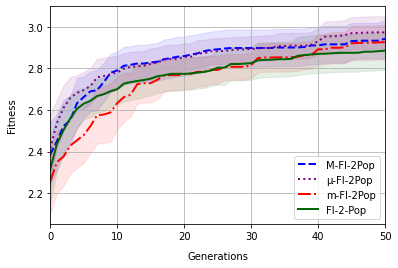

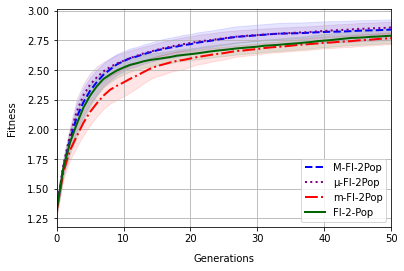

In [35]:
experiments = {
               'variant-fi2pop-max_merge': {},
               'variant-fi2pop-mean_merge': {},
               'variant-fi2pop-min_merge': {}
               }

for experiment in experiments.keys():
    with open(f'results/cog_experiment06/{experiment}_metrics.npz', 'rb') as f:
        npzfile = np.load(f)
        experiments[experiment]['feasible'] = npzfile['arr_0']
        experiments[experiment]['infeasible'] = npzfile['arr_1']

experiments['standard-fi2pop'] = {}
with open(f'results/cog_experiment01/standard-fi2pop_metrics.npz', 'rb') as f:
        npzfile = np.load(f)
        experiments['standard-fi2pop']['feasible'] = npzfile['arr_0']
        experiments['standard-fi2pop']['infeasible'] = npzfile['arr_1']


feas_arrs = []
infeas_arrs = []
labels = ['M-FI-2Pop', 'μ-FI-2Pop', 'm-FI-2Pop', 'FI-2-Pop']
for experiment in experiments.keys():
    feas_arrs.append(experiments[experiment]['feasible'])
    infeas_arrs.append(experiments[experiment]['infeasible'])
    
colors = ['blue', 'purple', 'red', 'darkgreen']
linestyles = ['dashed', 'dotted', 'dashdot', 'solid']

plot_compare(arrs=feas_arrs,
            colors=colors,
            linestyles=linestyles,
            labels=labels,
            dir_name='.',
            title=None,
            partial_filename='fi2pop-top-feas-fitness',
            plot_elites=True,
            add_area=True)

plot_compare(arrs=feas_arrs,
            colors=colors,
            linestyles=linestyles,
            labels=labels,
            dir_name='.',
            title=None,
            partial_filename='fi2pop-avg-feas-fitness',
            plot_elites=False,
            add_area=True)

## MAP-Elites

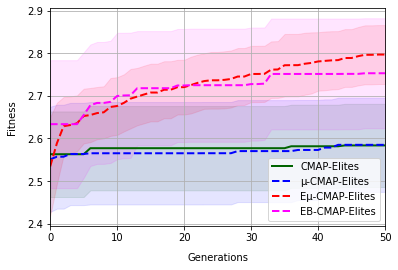

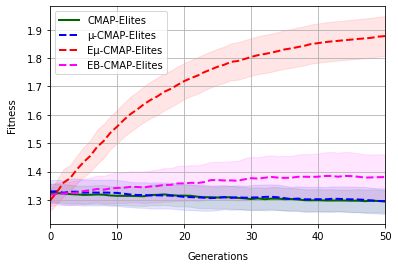

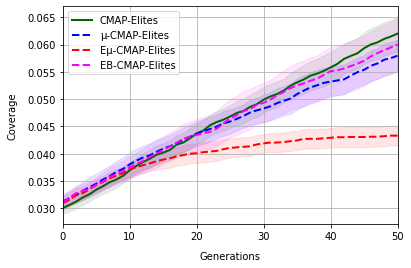

In [36]:
experiments = {}

experiments['standard-mapelites'] = {}
with open(f'results/cog_experiment02/standard-mapelites_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['standard-mapelites']['feasible'] = npzfile['arr_0']
with open(f'results/cog_experiment02/standard-mapelites_coverages.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['standard-mapelites']['feasible_coverage'] = np.expand_dims(
        npzfile['arr_0'], 2)

experiments['variant-mapelites-mean-merge'] = {}
with open(f'results/cog_experiment02/variant-mapelites-mean_merge_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-mapelites-mean-merge']['feasible'] = npzfile['arr_0']
with open(f'results/cog_experiment02/variant-mapelites-mean_merge_coverages.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-mapelites-mean-merge']['feasible_coverage'] = np.expand_dims(
        npzfile['arr_0'], 2)

# experiments['variant-optim-mapelites-mean-merge'] = {}
# with open(f'results/cog_experiment03/variant-optim-mapelites-mean_merge_metrics.npz', 'rb') as f:
#     npzfile = np.load(f)
#     experiments['variant-optim-mapelites-mean-merge']['feasible'] = npzfile['arr_0']
# with open(f'results/cog_experiment03/variant-optim-mapelites-mean_merge_coverages.npz', 'rb') as f:
#     npzfile = np.load(f)
#     experiments['variant-optim-mapelites-mean-merge']['feasible_coverage'] = np.expand_dims(
#         npzfile['arr_0'], 2)

experiments['variant-optim2-mapelites-mean-merge'] = {}
with open(f'results/cog_experiment05/variant-optim-mapelites-mean_merge_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-optim2-mapelites-mean-merge']['feasible'] = npzfile['arr_0']
with open(f'results/cog_experiment05/variant-optim-mapelites-mean_merge_coverages.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-optim2-mapelites-mean-merge']['feasible_coverage'] = np.expand_dims(
        npzfile['arr_0'], 2)

experiments['variant-bandit-mapelites-mean-merge'] = {}
with open(f'results/cog_experiment07/variant-bandit-mapelites-mean_merge_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-bandit-mapelites-mean-merge']['feasible'] = npzfile['arr_0']
with open(f'results/cog_experiment07/variant-bandit-mapelites-mean_merge_coverages.npz', 'rb') as f:
    npzfile = np.load(f)
    experiments['variant-bandit-mapelites-mean-merge']['feasible_coverage'] = np.expand_dims(
        npzfile['arr_0'], 2)

feas_arrs = []
feas_coverages = []
for experiment in experiments.keys():
    feas_arrs.append(experiments[experiment]['feasible'])
    feas_coverages.append(experiments[experiment]['feasible_coverage'])

labels = ['CMAP-Elites', 'μ-CMAP-Elites', 'Eμ-CMAP-Elites', 'EB-CMAP-Elites']

colors = ['darkgreen', 'blue', 'red', 'magenta']
linestyles = ['solid', 'dashed', 'dashed', 'dashed']

plot_compare(arrs=feas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             dir_name='.',
             title=None,
             partial_filename='mapelites-top-feas-fitness',
             plot_elites=True,
             add_area=True)

plot_compare(arrs=feas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             dir_name='.',
             title=None,
             partial_filename='mapelites-avg-feas-fitness',
             plot_elites=False,
             add_area=True,
            legend_loc='upper left')

plot_compare(arrs=feas_coverages,
            colors=colors,
            linestyles=linestyles,
            labels=labels,
            dir_name='.',
            title=None,
            partial_filename='mapelites-avg-coverage',
            plot_elites=True,
            add_area=True,
            legend_loc='upper left')